# **Informaciones**

**Trabajo personal, semana 6**

*Santiago Lamas Fresard*

# **Inicialización**

In [1]:
using Distributions, Gurobi, Ipopt, JuMP, LinearAlgebra, Measures, Plots, Random, Roots, SDDP

const GRB_ENV = Gurobi.Env()

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


Set parameter Username
Set parameter LicenseID to value 2760931
Academic license - for non-commercial use only - expires 2027-01-05


Gurobi.Env(Ptr{Nothing} @0x0000023c60741830, false, 0)

# **Modelos**

*Single-species, multiaged forest model, taken from "A Discussion of Vintage Optimization Models in Forest Economics", A. Piazza, Forest Science, Vol 66(4) pp.469-477, 2020.*

## **Estimación de la función de costos**

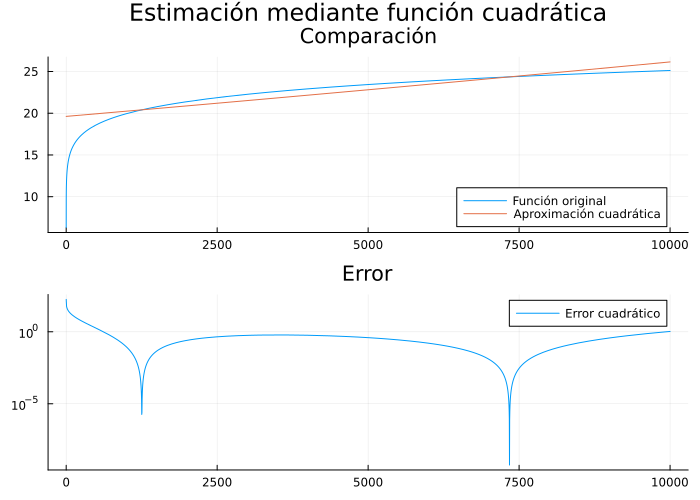

In [2]:
# Encuentra los parámetros que mejor aproximan la función x^(1-α)/(1-α) de acuerdo a la norma L^2([0,T])
function params_optimos(α, T)
    A = [T^5/5 T^4/4 T^3/3; T^4/4 T^3/3 T^2/2; T^3/3 T^2/2 T]
    b = [T^(4-α)/(4-α); T^(3-α)/(3-α); T^(2-α)/(2-α)]/(1-α)
    return A^-1*b
end

# Ejemplo: fijación de parámetros
α_ej, T_ej = 0.9, 10000
a_ej, b_ej, c_ej = params_optimos(α_ej, T_ej)

# Funciones a usar
quad_ej = x -> a_ej*x^2 + b_ej*x + c_ej
raiz_ej = x -> x^(1-α_ej)/((1-α_ej))
l2norm = x -> (quad_ej(x) - raiz_ej(x))^2

# Graficado
p1 = plot(raiz_ej, 0.01, T_ej, label="Función original")
plot!(quad_ej, 0.01, T_ej, label="Aproximación cuadrática", title="Comparación")
p2 = plot(l2norm, 0.01, T_ej, yaxis=:log10, label="Error cuadrático", title="Error")
plot(p1, p2, layout=(2,1), size=(700,500), plot_title="Estimación mediante función cuadrática")

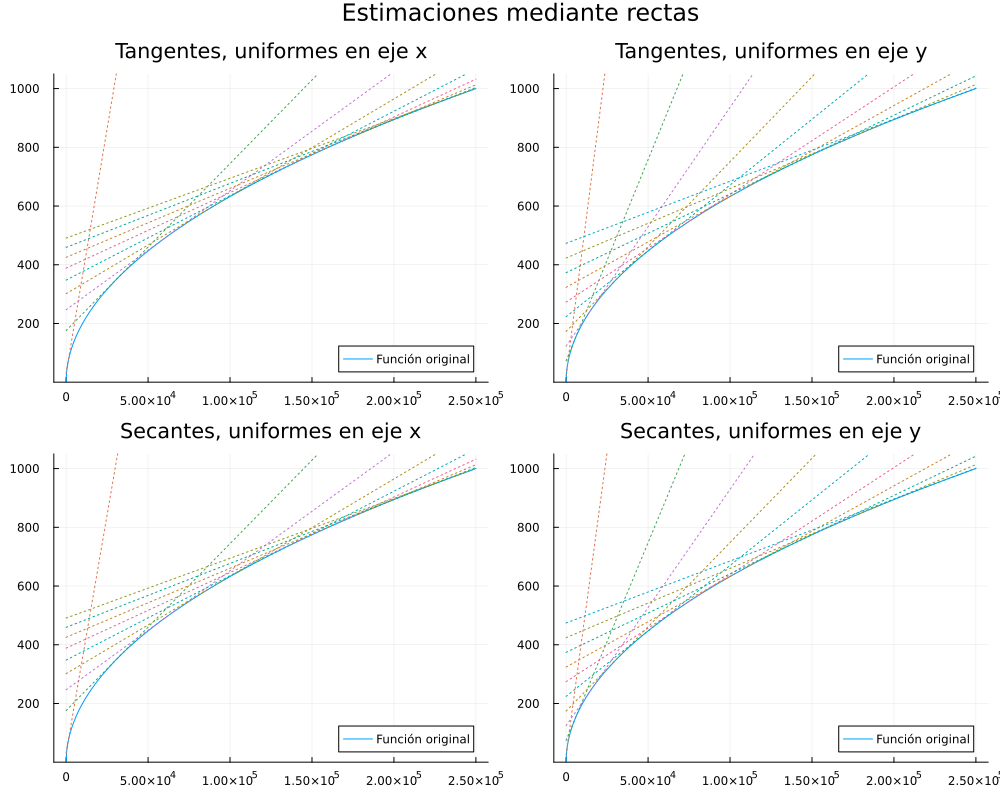

In [3]:
# Parámetros a usar en el problema
α = 0.5 # risk aversion parameter for the utility function
UB = 1000 # upper bound for the objective function

# Funciones útiles
obj = x -> x^(1-α)/(1-α) # función objetivo
deriv_obj = x -> x^-α # derivada de función objetivo
inv_obj = y -> ((1-α)*y)^(1/(1-α)) # inversa de función objetivo

# Parámetros para estimar la función objetivo
T = inv_obj(UB)
nx, ny = 2500, 200 # número de puntos para discretizar 
dx, dy = T/nx, UB/ny # pasos para discretizar

# Aproximación por una función cuadrática
a, b, c = params_optimos(α, T)
approx_quad = x -> a*x^2 + b*x + c

# Discretización de los intervalos a trabajar
d_unif_x = 1:dx:T # uniforme en eje x
d_unif_y = 1:dy:UB          # uniforme en eje y

# Imagen y preimagen de las discretizaciones
f_unif_x = obj.(d_unif_x)    # uniforme en eje x
f_inv_y = inv_obj.(d_unif_y) # uniforme en eje y

# Aproximación mediante tangentes:
a_tgte_x = deriv_obj.(d_unif_x)             # pendiente uniforme en eje x
b_tgte_x = f_unif_x .- a_tgte_x .* d_unif_x # ordenada al origen uniforme en eje x
a_tgte_y = deriv_obj.(f_inv_y)              # pendiente uniforme en eje y
b_tgte_y = d_unif_y .- a_tgte_y .* f_inv_y  # ordenada al origen uniforme en eje y

# Aproximación mediante interpolación lineal:
a_interp_x = [(f_unif_x[i+1] - f_unif_x[i])/dx for i in 1:nx-1] # pendiente uniforme en eje x
b_interp_x = f_unif_x[1:nx-1] .- a_interp_x .* d_unif_x[1:nx-1] # ordenada al origen uniforme en eje x
a_interp_y = [dy/(f_inv_y[i+1] - f_inv_y[i]) for i in 1:ny-1]   # pendiente uniforme en eje y
b_interp_y = d_unif_y[1:ny-1] .- a_interp_y .* f_inv_y[1:ny-1]  # ordenada al origen uniforme en eje y

# Graficado
p1 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Tangentes, uniformes en eje x")
for i in 10:300:nx
    plot!(x -> a_tgte_x[i]*x + b_tgte_x[i], label=false, linestyle=:dot)
end
p2 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Tangentes, uniformes en eje y")
for i in 10:20:ny
    plot!(x -> a_tgte_y[i]*x + b_tgte_y[i], label=false, linestyle=:dot)
end
p3 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Secantes, uniformes en eje x")
for i in 10:300:nx-1
    plot!(x -> a_interp_x[i]*x + b_interp_x[i], label=false, linestyle=:dot)
end
p4 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Secantes, uniformes en eje y")
for i in 10:20:ny-1
    plot!(x -> a_interp_y[i]*x + b_interp_y[i], label=false, linestyle=:dot)
end
plot(p1, p2, p3, p4, layout=(2,2), size=(1000,800), plot_title="Estimaciones mediante rectas")

## **Prueba de modelos**

### **Fijación de parámetros**

In [4]:
UB = 1000 # upper bound for the objective function
b = 0.975 # discount factor used by Buongiorno
α = 0.5 # risk aversion parameter for the utility function
n = 5 # number of age classes
f = [0.8, 4.2, 16.99, 68.1, 84] # biomass coeffcients
x0 = [1.0, 0.0, 0.0, 0.0, 0.0] # initial state

# Creamos un gráfico cíclico de un nodo con probablidad (1-b) de salir del ciclo 
graph = SDDP.UnicyclicGraph(b; num_nodes = 1)

# Número de iteraciones para entrenar y simulaciones
n_train_iterations = 50
n_simulations = 1

1

### **Función cuadrática**

In [5]:
model0 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
    end)
    @stageobjective(sp, approx_quad(TV))
end

A policy graph with 1 nodes.
 Node indices: 1


In [6]:
println("Aproximación cuadrática:")
SDDP.numerical_stability_report(model0)

Aproximación cuadrática:
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]


In [7]:
# SDDP.train(model0, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
# simulations = SDDP.simulate(model0, n_simulations, [:x])
# objective_values = [
    # sum(stage[:stage_objective] for stage in sim) for sim in simulations
# ]
# μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
# lower_bound = SDDP.calculate_bound(model0)
# println("Confidence interval: ", μ, " ± ", ci)
# # println("Lower bound: ", round(lower_bound, digits = 2))

### **Método de la tangente uniforme en x**

In [8]:
model1 = SDDP.PolicyGraph(
    graph;
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional.
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:nx], u <= a_tgte_x[s]*TV + b_tgte_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [9]:
println("Aproximación tangencial uniforme en x:")
SDDP.numerical_stability_report(model1)

Aproximación tangencial uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]


In [10]:
# SDDP.train(model1, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
# simulations = SDDP.simulate(model1, n_simulations, [:x])
# objective_values = [
    # sum(stage[:stage_objective] for stage in sim) for sim in simulations
# ]
# μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
# lower_bound = SDDP.calculate_bound(model1)
# println("Confidence interval: ", μ, " ± ", ci)
# println("Lower bound: ", round(lower_bound, digits = 2))

### **Método de la tangente uniforme en y**

In [11]:
model2 = SDDP.PolicyGraph(
    graph;
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:ny], u <= a_tgte_y[s]*TV + b_tgte_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [12]:
println("Aproximación tangencial uniforme en y:")
SDDP.numerical_stability_report(model2)

Aproximación tangencial uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]


In [13]:
# SDDP.train(model2, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
# simulations = SDDP.simulate(model2, n_simulations, [:x])
# objective_values = [
    # sum(stage[:stage_objective] for stage in sim) for sim in simulations
# ]
# μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
# lower_bound = SDDP.calculate_bound(model2)
# println("Confidence interval: ", μ, " ± ", ci)
# println("Lower bound: ", round(lower_bound, digits = 2))

### **Método de la secante uniforme en x**

In [14]:
model3 = SDDP.PolicyGraph(
    graph;
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: nx-1], u <= a_interp_x[s]*TV + b_interp_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [15]:
println("Aproximación interpolando uniforme en x:")
SDDP.numerical_stability_report(model3)

Aproximación interpolando uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]


In [16]:
# SDDP.train(model3, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
# simulations = SDDP.simulate(model3, n_simulations, [:x])
# objective_values = [
    # sum(stage[:stage_objective] for stage in sim) for sim in simulations
# ]
# μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
# lower_bound = SDDP.calculate_bound(model3)
# println("Confidence interval: ", μ, " ± ", ci)
# println("Lower bound: ", round(lower_bound, digits = 2))

### **Método de la secante uniforme en y**

In [17]:
model4 = SDDP.PolicyGraph(
    graph;
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: ny-1], u <= a_interp_y[s]*TV + b_interp_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [18]:
println("Aproximación interpolando uniforme en y:")
SDDP.numerical_stability_report(model4)

Aproximación interpolando uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]


In [19]:
# SDDP.train(model4, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
# simulations = SDDP.simulate(model4, n_simulations, [:x])
# objective_values = [
    # sum(stage[:stage_objective] for stage in sim) for sim in simulations
# ]
# μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
# lower_bound = SDDP.calculate_bound(model4)
# println("Confidence interval: ", μ, " ± ", ci)
# println("Lower bound: ", round(lower_bound, digits = 2))

# **Simulaciones**

## **Euler-Maruyama**

In [20]:
# Constants and matrices
α_d, β_d      = 35.3462, 0.0280        # fixed-effects diameter intercept & pull-back (Table 2 in the paper)
α_h, β_h      = 25.3301, 0.0396        # fixed-effects height intercept & pull-back (Table 2 in the paper)
σ11, σ12, σ22 = 2.3736, 0.6334, 0.3615  # mixed-effects diffusion entries (PD!). For the fixed ones,the matrix is singular
mu = [α_d, α_h] 
gamma = Diagonal([β_d, β_h])
B = [σ11 σ12; σ12 σ22]


2×2 Matrix{Float64}:
 2.3736  0.6334
 0.6334  0.3615

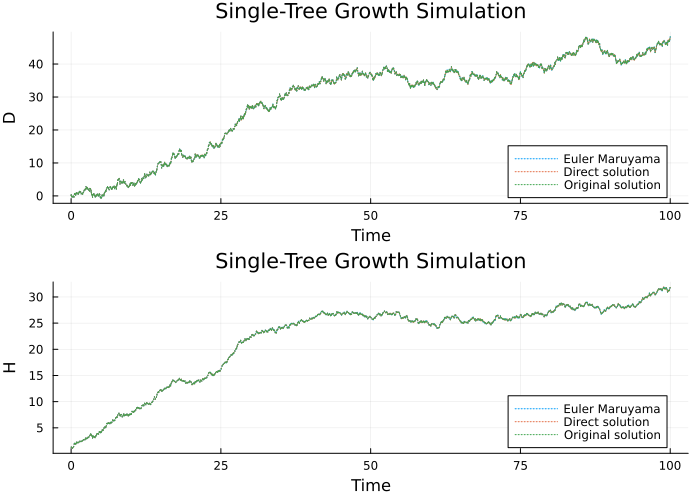

In [21]:
# Basic simulation info
T       = 100 # time horizon
n       = 5000 # number of steps
Δt      = T/n # time step
x0      = [0.1, 1.3]  # start (diameter, height) at t0
sqB     = sqrt(B) # matrix B^1/2

# Allocate & initialize
EM = Array{Float64}(undef, 2, n+1) # Euler-Maruyama scheme
EM[:,1] .= x0
DS = Array{Float64}(undef, 2, n+1) # direct solution
DS[:,1] .= x0
OS = Array{Float64}(undef, 2, n+1) # original scheme
OS[:,1] .= x0
BI = [0, 0] # brownian integral

# Useful matrices
F = exp(-gamma * Δt)
Q = [ σ11*(1-exp(-2β_d*Δt))/(2β_d)     σ12*(1-exp(-(β_d+β_h)*Δt))/(β_d+β_h);
      σ12*(1-exp(-(β_d+β_h)*Δt))/(β_d+β_h)   σ22*(1-exp(-2β_h*Δt))/(2β_h) ]
I2 = Matrix{Float64}(I, 2, 2)

# Simulate forward from k=1..n between Euler-Maruyama, the direct solution and the original simulations
rng = MersenneTwister(39) # fix random seed
dist = MvNormal(zeros(2), Δt*I2)
for k in 1:n
    η = rand(rng, dist)
    EM[:,k+1] = EM[:,k] + gamma*(mu - EM[:,k])*Δt .+ sqB * η
    BI += exp(gamma*Δt*(k-1)) * sqB * η
    DS[:,k+1] = mu .+ exp(-gamma*Δt*k)*(x0 .- mu .+ BI)
    OS[:,k+1] = mu .+ F*(OS[:,k] - mu) .+ sqrt(Q/Δt)*η
end

# Plot the single trajectory

t = 0:Δt:T
p1 = plot(t, EM[1,:], label="Euler Maruyama", xlabel="Time", ylabel="D", legend=:bottomright, linestyle=:dot)
plot!(t, DS[1,:], label="Direct solution", xlabel="Time", ylabel="D", legend=:bottomright, linestyle=:dot)
plot!(t, OS[1,:], label="Original solution", xlabel="Time", ylabel="D", legend=:bottomright, linestyle=:dot)
p2 = plot(t, EM[2,:], label="Euler Maruyama", xlabel="Time", ylabel="H", legend=:bottomright, linestyle=:dot)
plot!(t, DS[2,:], label="Direct solution", xlabel="Time", ylabel="H", legend=:bottomright, linestyle=:dot)
plot!(t, OS[2,:], label="Original solution", xlabel="Time", ylabel="H", legend=:bottomright, linestyle=:dot)
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [ ]:
samples = 20000

# Allocate & initialize
Xs = Array{Float64, 3}(undef, 2, n+1, samples)
X0 = reshape(repeat(x0, samples), (2, samples))
Xs[:,1,:] .= X0

# Simulate forward from k=1..n
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt*I2)
# for k in 1:n
    # for j in 1:samples
        # η = rand(rng, dist)
        # Xs[:,k+1,j] = Xs[:,k,j] .+ gamma*(mu .- Xs[:,k,j])*Δt .+ sqB * η
    # end
# end

In [ ]:
# Plot the trajectories
# t = 0:Δt:T
# p1 = plot(t, Xs[1,:,1:20], xlabel="Time", ylabel="D", legend=false)
# p2 = plot(t, Xs[2,:,1:20], xlabel="Time", ylabel="H", legend=false)
# plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [ ]:
# site_idx = mean(sort(Xs[2,40*50,:])[end-100:end])

## **''Markovianización'' del conjunto de estados**

Se toma la siguiente simplificación del modelo: Cada 5 años, se clasifican el diámetro y la altura de cada árbol según clases de los siguientes rangos: 5 cm para el diámetro y 5 m para la altura. Se omite la posibilidad de tomar valores negativos (factible según el modelo)

In [ ]:
# Espaciado de las muestras para samplear cada 5 años
t_muestras = floor(Int,5/Δt)
# Clasificación de los árboles
Ys = max.(floor.(Int, Xs[:,1:t_muestras:end,:]/5),0)

# Se registran todas las posibles transiciones.
key_list = [([d1,h1], [d2,h2]) for d1 in 0:12, d2 in 0:12, h1 in 0:6, h2 in 0:6]
# Diccionario que contará todas las transiciones.
total_transiciones = Dict(key => 0 for key in key_list)

# Se cuentan todas las transiciones dada la simplificación.
for i in 1:samples
    for k in 1:size(Ys)[2]-1
        total_transiciones[Ys[:,k,i],Ys[:,k+1,i]] += 1
    end
end

sumas_transiciones = Dict()
valid_idx = []
for d1 in 0:9
    for h1 in 0:6
        s = sum(total_transiciones[[d1,h1],[d2,h2]] for d2 in 0:9, h2 in 0:6)
        # Omitir estados visitados menos del 1% del número de trayectorias
        if s >= samples/100 
            sumas_transiciones[[d1,h1]] = s
            push!(valid_idx, [d1,h1])
        end
    end
end

In [ ]:
# SOLO PARA INICIALIZAR
# 
# touch("markovian.txt")
# touch("markovian_sum.txt")
# io = open("markovian.txt", "w")
# io_sum = open("markovian_sum.txt", "w")
# 
# mc = Dict()
# mc_sum = Dict()
# for ik in valid_idx
    # s = sumas_transiciones[ik]
    # print("Estado de partida: ")
    # println(ik)
    # println(" ")
    # for jl in valid_idx
        # mc[ik,jl] = trunc(round(total_transiciones[ik,jl]/s; digits=4); digits = 2)
        # mc_str = string(ik,jl,mc[ik,jl],"\n") 
        # write(io, mc_str)
        # if mc[ik,jl] > 0
            # print("Estado de llegada: ")
            # print(jl)
            # print(", prob. de transición = ")
            # println(mc[ik,jl])
        # end
    # end
    # mc_sum[ik] = sum(mc[ik,jl] for jl in valid_idx)
    # mc_sum_str = string(ik,mc_sum[ik],"\n") 
    # write(io_sum, mc_sum_str)
    # print("Suma de probs. de transición = ")
    # println(mc_sum[ik])
    # println(" ")
    # println("------------------")
    # println(" ")
# end
# 
# close(io)
# close(io_sum)

In [ ]:
mc = Dict()
mc_sum = Dict()
mc_norm = Dict()
valid_idx = []

io = open("markovian.txt", "r")
for line in eachline(io)
  str_d1, str_h1, str_d2, str_h2, str_val = line[2], line[5], line[8], line[11], line[13:end]
  pd1, ph1, pd2, ph2 = parse(Int64, str_d1), parse(Int64, str_h1), parse(Int64, str_d2), parse(Int64, str_h2)
  val = parse(Float64, str_val)
  mc[[pd1, ph1], [pd2, ph2]] = val
  if !([pd1, ph1] in valid_idx)
      push!(valid_idx, [pd1, ph1])
  end
end

io_sum = open("markovian_sum.txt", "r")
for line in eachline(io_sum)
  str_d, str_h, str_val = line[2], line[5], line[7:end]
  pd, ph = parse(Int64, str_d), parse(Int64, str_h)
  val = parse(Float64, str_val)
  mc_sum[[pd, ph]] = val
end

for ik in valid_idx
    s = mc_sum[ik]
    for jl in valid_idx
        mc_norm[ik,jl] = mc[ik,jl]/s
    end
end

# **Extensión del modelo Markovianizado**

## **Creación del modelo**

In [ ]:
N = length(valid_idx)

x0_test = zeros(N)
x0_test[1] = 1
f_test = Float64[]
BAs = Float64[]
rel = Dict()
for i in 1:N
    push!(f_test, 1)
    i_d, i_h = valid_idx[i]
    rel[i] = [i_d, i_h]
    d_i = 5*i_d + 2.5
    push!(BAs, pi*d_i^2/40000) 
end

tr_mtx = zeros(N,N)
tr_mtx_norm = zeros(N,N)
for i in 1:N
    for j in 1:N
        tr_mtx[i,j] = mc[(rel[i],rel[j])]
        tr_mtx_norm[i,j] = mc_norm[(rel[i],rel[j])]
    end
end

In [ ]:
a0 = -3.552
a1 = -0.062 
a3 = 0.016

function p_rec(BA)
    return (1 + e^-(a0 + a3 + a1*BA))^-1
end

function dp_rec(BA)
    return a1 / (2*cosh(a0 + a3 + a1*BA) + 2)
end

b0 = 67.152
b1 = -0.076

function c_rec(BA)
    return b0 * BA^b1
end

function dc_rec(BA)
    return b0 * b1*BA^(b1-1)
end

# **Extensión del modelo con regeneración**

El modelo de regeneración a usar corresponde a aquel trabajado en Bollandsas et al, en el cual en cada etapa, el número de árboles de la especie $i\in\{1,\ldots, N\}$ de la primera clase de altura y diámetro corresponde al producto $\pi_i \times CR_i$, con 
- $\pi_i = \frac{e^{\alpha_{i0} + \alpha_{i1} BA + \alpha_{i2} SI + \alpha_{i3} PBA}}{1 + e^{\alpha_{i0} + \alpha_{i1} BA + \alpha_{i2} SI + \alpha_{i3} PBA}}$
- $CR_i = \beta_{i0} BA^{\beta_{i1}} SI^{\beta_{i2}} PBA^{\beta_{i3}}$

En particular, se asume que el área en la cual se trabaja es exactamente una hectárea, el site index SI corresponde a la altura promedio de los árboles dominantes de 40 años y el PBA es idéntico a 1 al existir una única especie.

In [ ]:
a_10, a_11, a_12, a_13 = (-2.291, -0.018, 0.066, 0.019)
a_20, a_21, a_22, a_23 = (-3.552, -0.062, 0, 0.031)
a_30, a_31, a_32, a_33 = (-0.904, -0.037, 0, 0.016)
a_40, a_41, a_42, a_43 = (-3.438, -0.029, 0.123, 0.048)

SI = 22 #DE JUGUETE

function pi_1(BA)
    return 1/(1 + exp(-(a_10 + a_11*BA + a_12*SI + a_13)))
end
function pi_2(BA)
    return 1/(1 + exp(-(a_20 + a_21*BA + a_22*SI + a_23)))
end
function pi_3(BA)
    return 1/(1 + exp(-(a_30 + a_31*BA + a_32*SI + a_33)))
end
function pi_4(BA)
    return 1/(1 + exp(-(a_40 + a_41*BA + a_42*SI + a_43)))
end

plot(pi_1, 0,80)
plot!(pi_2, 0,80)
plot!(pi_3, 0,80)
plot!(pi_4, 0,80)

In [ ]:
b_10, b_11, b_12 = (43.142, -0.157, 0.368)
b_20, b_21, b_22 = (67.152, -0.076, 0)
b_30, b_31, b_32 = (64.943, -0.161, 0.143)
b_40, b_41, b_42 = (31.438, -0.1695, 0.442)

SI = 22 #DE JUGUETE

function CR_1(BA)
    return b_10* BA^b_11 * SI^b_12
end
function CR_2(BA)
    return b_20* BA^b_21 * SI^b_22
end
function CR_3(BA)
    return b_30* BA^b_31 * SI^b_32
end
function CR_4(BA)
    return b_40* BA^b_41 * SI^b_42
end

plot(CR_1, 0,80)
plot!(CR_2, 0,80)
plot!(CR_3, 0,80)
plot!(CR_4, 0,80)

In [ ]:
function d1(BA)
    return pi_1(BA)*CR_1(BA+0.001)
end

function d2(BA)
    return pi_2(BA)*CR_2(BA+0.001)
end

function d2_app(BA)
    x1, y1 = 5, d2(5)
    x2, y2 = 35, d2(35)
    return BA*(y2 - y1)/(x2 -x1) + y1
end

function d3(BA)
    return pi_3(BA)*CR_3(BA+0.001)
end

function d4(BA)
    return pi_4(BA)*CR_4(BA+0.001)
end
plot(d1, 0.2,43)
plot!(d2, 0.2,43)
plot!(d2_app, 0.2, 43)
plot!(d3, 0.2,43)
plot!(d4, 0.2,43)

In [ ]:
N_por_diam = 18.4/sum(d^2*pi/40000 for d in 2.5:5:37.5)

x0_mvp = zeros(N)
x0_mvp[1] = N_por_diam*7
UB = 1000

f_reg = Float64[]
for i in 1:n
    push!(f_reg, 0.01)
end

# **Minimum viable product**

In [ ]:
# rel[30][1] = 8
# 
# num_classes = Int64[]
# counter = 0
# 
# i = 1
# while i <= N && counter <100
    # current_diam = rel[i][1]
    # println(current_diam)
    # j = 0
    # next_diam = current_diam
    # while current_diam == next_diam && i+j <= N && counter <100
        # next_diam = rel[i+j][1]
        # j += 1
        # counter += 1
        # print(i)
        # print(" ")
        # println(j)
    # end
    # print("while ended:")
    # println(j-1)
    # push!(num_classes, j)
    # i += j
    # println(i)
    # counter += 1    
# end

In [ ]:
num_classes = [3, 4, 4, 4, 4, 3, 3, 2, 2, 1]
cumnum_classes = cumsum(num_classes)
sum_mtx = zeros(10,N)
for j in 1:10
    first = (cumnum_classes - num_classes)[j] + 1
    last = cumnum_classes[j]
    sum_mtx[j,first:last] .= 1
end

## **Sin función de regeneración**

In [ ]:
legends = ["[0,5] cm" "[5,10] cm" "[10,15] cm" "[15,20] cm" "[20,25] cm" "[25,30] cm" "[30,35] cm" "[35,40] cm" "[40,45] cm" "[45,50] cm"]
legends_pie = ["[0,5] cm", "[5,10] cm", "[10,15] cm", "[15,20] cm", "[20,25] cm", "[25,30] cm",
     "[30,35] cm", "[35,40] cm", "[40,45] cm", "[45,50] cm"]

In [ ]:
Z_no_reg =  Array{Float64}(undef, 200, N) 
Z_no_reg_norm =  Array{Float64}(undef, 200, N) 
Z_no_reg[1,:] = transpose(x0_mvp)
Z_no_reg_norm[1,:] = transpose(x0_mvp)

for k in 2:200
    Z_no_reg[k,:] = transpose(Z_no_reg[k-1,:])*tr_mtx
    Z_no_reg_norm[k,:] = transpose(Z_no_reg_norm[k-1,:])*tr_mtx_norm
end 
pie_no_reg = sum_mtx*Z_no_reg_norm[end,:]

p1 = plot(Z_no_reg*transpose(sum_mtx) .+ 1, yaxis=:log10, label = legends, 
    left_margin=5mm, title = "Con mortalidad", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
p2 = plot(Z_no_reg_norm*transpose(sum_mtx) .+ 1, yaxis=:log10, label = legends, 
    title = "Sin mortalidad", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
p3 = pie(legends_pie, pie_no_reg, 
    title = "Distribución en equilibrio sin mortalidad", l = 0.5)
plot(p1, p2, p3, layout=(3,1), size=(500,900), 
plot_title="Evolución sin tala ni regeneración")

## **Con función de regeneración, sin tala:**

In [ ]:
Z_reg =  Array{Float64}(undef, 100, N) 
Z_reg_norm =  Array{Float64}(undef, 100, N) 
Z_reg[1,:] = transpose(x0_mvp)
Z_reg_norm[1,:] = transpose(x0_mvp)
for k in 2:100
    BA = sum(BAs[s] * Z_reg[k-1,s] for s in 2:N)
    Z_reg[k,:] = transpose(Z_reg[k-1,:])*tr_mtx
    Z_reg[k,1] += d4(BA)
    BA_norm = sum(BAs[s] * Z_reg_norm[k-1,s] for s in 2:N)
    Z_reg_norm[k,:] = transpose(Z_reg_norm[k-1,:])*tr_mtx_norm
    Z_reg_norm[k,1] += d4(BA_norm)
end 
pie_reg = sum_mtx*Z_reg[end,:]
pie_reg_norm = sum_mtx*Z_reg_norm[end,:]

print("Masa total en equilibrio = ")
p1 = plot(Z_reg*transpose(sum_mtx) .+ 1, yaxis=:log10, label = legends, 
    left_margin=5mm, title = "Con mortalidad", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
p2 = plot(Z_reg_norm*transpose(sum_mtx) .+ 1, yaxis=:log10, label = legends, 
    title = "Sin mortalidad", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
p3 = pie(legends_pie, pie_reg, 
    title = "Distribución en equilibrio\n con mortalidad", l = 0.5)
p4 = pie(legends_pie, pie_reg_norm, 
    title = "Distribución en equilibrio\n sin mortalidad", l = 0.5)
plot(p1, p2, p3, p4, layout=(2,2), size=(800,700), 
plot_title="Evolución sin tala con regeneración")

## **Con función de regeneración, con tala:**

In [ ]:
frac_tala = [1, 1, 1, 1, 1,
    0.8, 0.8, 0.8, 0.8, 0.8,
    0.6, 0.6, 0.6, 0.6, 0.6,
    0.4, 0.4, 0.4, 0.4, 0.4,
    0.4, 0.4, 0.4, 0.4, 0.4,
    0.4, 0.4, 0.4, 0.4, 0.4,
]

Z_reg_tala =  Array{Float64}(undef, 100, N) 
Z_reg_tala_norm =  Array{Float64}(undef, 100, N) 
Z_reg_tala[1,:] = transpose(x0_mvp)
Z_reg_tala_norm[1,:] = transpose(x0_mvp)
for k in 2:100
    BA = sum(BAs[s] * Z_reg_tala[k-1,s] for s in 2:N)
    Z_reg_tala[k,:] = transpose(Z_reg_tala[k-1,:])*tr_mtx.*transpose(frac_tala)
    Z_reg_tala[k,1] += d4(BA)
    BA_norm = sum(BAs[s] * Z_reg_tala_norm[k-1,s] for s in 2:N)
    Z_reg_tala_norm[k,:] = transpose(Z_reg_tala_norm[k-1,:])*tr_mtx_norm.*transpose(frac_tala)
    Z_reg_tala_norm[k,1] += d4(BA_norm)
end 
pie_reg_tala = sum_mtx*Z_reg_tala[end,:]
pie_reg_tala_norm = sum_mtx*Z_reg_tala_norm[end,:]

print("Masa total en equilibrio = ")
p1 = plot(Z_reg_tala*transpose(sum_mtx) .+ 1, yaxis=:log10, label = legends, 
    left_margin=5mm, title = "Con mortalidad", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
p2 = plot(Z_reg_tala_norm*transpose(sum_mtx) .+ 1, yaxis=:log10, label = legends, 
    title = "Sin mortalidad", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
p3 = pie(legends_pie, pie_reg_tala, 
    title = "Distribución en equilibrio\n con mortalidad", l = 0.5)
p4 = pie(legends_pie, pie_reg_tala_norm, 
    title = "Distribución en equilibrio\n sin mortalidad", l = 0.5)
plot(p1, p2, p3, p4, layout=(2,2), size=(800,700), 
plot_title="Evolución sin tala con regeneración")

# **Modelo de diámetro**

*Simplification of the model introduced in "Self-learning growth simulator for modelling forest stand dynamics in changing conditions", Timo Pukkala, Jari Vauhkonen, Kari T. Korhonen and Tuula Packalen*

## **En función del diámetro individual**

In [ ]:
coefs_diam_pine = [-7.1552, 0.4415, -0.0685, -0.2027, -0.1236, 1.1198]
coefs_diam_spruce = [-12.7527, 0.1693, -0.0301, -0.1875, -0.0563, 1.9747]
coefs_diam_broadleaf = [-8.6306, 0.5097, -0.0829, -0.3864, -0.0545,  1.3163]

vars_diam = d -> [1, sqrt(d), d, log(25+1), 10/sqrt(d+1), log(1100)]
delta_diam_pine = d -> exp(sum(coefs_diam_pine.*vars_diam(d)))
delta_diam_spruce = d -> exp(sum(coefs_diam_spruce.*vars_diam(d)))
delta_diam_broadleaf = d -> exp(sum(coefs_diam_broadleaf.*vars_diam(d)))

x = 0:0.1:40
plot(x, 
    [delta_diam_pine, delta_diam_spruce, delta_diam_broadleaf], 
    xlabel="Diámetro [cm]", 
    ylabel="Aumento de diámetro [cm/5 años]",
    title="Aumento en el diámetro de árboles",
    label=["Pino" "Abeto" "Hojas amplias"])

In [ ]:
Nd = 8

diam_tr = zeros(Nd,Nd)
for i in 1:Nd
    help_func = d -> d + delta_diam_pine(d) - 5*i
    crit_pt = find_zero(help_func, 5*i)
    frac_ret = (crit_pt - 5*(i-1))/5
    diam_tr[i,i] = frac_ret
    if i<Nd
        diam_tr[i+1,i] = 1 - frac_ret
    end
end

In [ ]:
mixed_coefs_survival_pine = [4.1505, 3.1513, -0.3575, -0.4001]
mixed_coefs_survival_spruce = [9.6649, 1.0157, -0.1577, -0.3244]
mixed_coefs_survival_broadleaf = [3.6655, 1.0650, -0.1509, -0.0326]

fixed_coefs_survival_pine = [1.41223, 1.8852, -0.21317, -0.25637]
fixed_coefs_survival_spruce = [5.01677, 0.36902, -0.07504, -0.2319]
fixed_coefs_survival_broadleaf = [1.60895, 0.71578, -0.08236, -0.13481]

function vars_survival(d)
    return [1, sqrt(d), d, 15/sqrt(d+1)]
end    

function mixed_survival_pine(d)
    return 1/(1+exp(-sum(mixed_coefs_survival_pine.*vars_survival(d))))
end
function mixed_survival_spruce(d)
    return 1/(1+exp(-sum(mixed_coefs_survival_spruce.*vars_survival(d))))
end
function mixed_survival_broadleaf(d)
    return 1/(1+exp(-sum(mixed_coefs_survival_broadleaf.*vars_survival(d))))
end

function fixed_survival_pine(d)
    return 1/(1+exp(-sum(fixed_coefs_survival_pine.*vars_survival(d))))
end
function fixed_survival_spruce(d)
    return 1/(1+exp(-sum(fixed_coefs_survival_spruce.*vars_survival(d))))
end
function fixed_survival_broadleaf(d)
    return 1/(1+exp(-sum(fixed_coefs_survival_broadleaf.*vars_survival(d))))
end

x = 0.1:0.01:30
plot(x, 
    [mixed_survival_pine, mixed_survival_spruce, 
        mixed_survival_broadleaf, fixed_survival_pine, 
        fixed_survival_spruce, fixed_survival_broadleaf], 
    xaxis=:log10,
    xlabel="Diámetro [cm]", 
    ylabel="Fracción de árboles supervivientes",
    title="Supervivencia de árboles",
    label=["Pino (mixed)" "Abeto (mixed)" "Hojas amplias (mixed)" "Pino (fixed)" "Abeto (fixed)" "Hojas amplias (fixed)"])

In [ ]:
coefs_ingrowth_pine = [-6.6933, 1.9051, -0.5035]
coefs_ingrowth_spruce = [-9.6128, 2.2897, -0.8739]
coefs_ingrowth_birch = [-3.2919, 1.5438, -1.2920]
coefs_ingrowth_other = [-48.4331,  7.6107, -0.2227]

function vars_ingrowth(d)
    return [1, log(1100), sqrt(25)]
end  

function ingrowth_pine(d)
    return exp(sum(coefs_ingrowth_pine.*vars_ingrowth(d)))
end
function ingrowth_spruce(d)
    return exp(sum(coefs_ingrowth_spruce.*vars_ingrowth(d)))
end
function ingrowth_birch(d)
    return exp(sum(coefs_ingrowth_birch.*vars_ingrowth(d)))
end
function ingrowth_other(d)
    return exp(sum(coefs_ingrowth_other.*vars_ingrowth(d)))
end

x = 0.01:0.01:30
plot(x, 
    [ingrowth_pine, ingrowth_spruce, 
        ingrowth_birch, ingrowth_other], 
    xaxis=:log10,
    xlabel="Diámetro [cm]", 
    ylabel="Número de árboles nacidos por ha.",
    title="Crecimiento de árboles",
    label=["Pino" "Abeto" "Abedul" "Otros"])

In [ ]:
X = Array{Float64}(undef, 100, Nd)
X[1,:] = zeros(Nd)
X[1,1] = 500
prom_diams = [5*i + 2.5 for i in 0:7]

for i in 2:100
    X[i,:] = diam_tr * (X[i-1,:] .* fixed_survival_pine.(prom_diams))
    X[i,1] += ingrowth_pine(2.5)
end

print("Masa total en equilibrio = ")
println(sum(X[end,:]))
plot(
    X .+ 1, 
    yaxis=:log10, 
    label = legends, 
    title = "Evolución del número de árboles acorde al diámetro", 
    xlabel = "Tiempo (años)", 
    ylabel = "Número de árboles + 1"
    )

In [ ]:
y = X[end,:]
pie(legends_pie, y, title = "Distribución de las clases de diámetro en equilibrio", l = 0.5)

## **En función del conjunto**

In [ ]:
BAs = [pi*i^2/40000 for i in 2.5:5:37.5]
help_BAL = zeros(Nd)

function vars_diam(d, X)
    G = sum(BAs.*X)
    num = floor(Int, d/5) + 1
    help_BAL[num:Nd] .= 1
    BAL = sum(BAs.*X.*help_BAL)
    return [1, sqrt(d), d, log(G+1), BAL/sqrt(d+1), log(1100)]
end    
function delta_diam_pine(d, X)
    return exp(sum(coefs_diam_pine.*vars_diam(d,X)))
end

function vars_survival(d, X)
    G = sum(BAs.*X)
    return [1, sqrt(d), d, G/sqrt(d+1)]
end    
function mixed_survival_pine(d, X)
    return 1/(1+exp(-sum(mixed_coefs_survival_pine.*vars_survival(d, X))))
end

function vars_ingrowth(d, X)
    G = sum(BAs.*X)
    return [1, log(1100), sqrt(G)]
end  
function ingrowth_pine(d, X)
    return exp(sum(coefs_ingrowth_pine.*vars_ingrowth(d, X)))
end

In [ ]:
mixed_survival_pine(2.5, X[1,:])

In [ ]:
X = Array{Float64}(undef, 300, Nd)
X[1,:] = zeros(Nd)
X[1,1] = 600
prom_diams = [5*i + 2.5 for i in 0:7]

for i in 2:300
    Z = X[i-1,:]
    prob = zeros(Nd)
    for i in 1:8
        diam_prom = 5*i - 2.5
        prob[i] = mixed_survival_pine(diam_prom, Z)
    end
    X[i,:] = diam_tr * (X[i-1,:] .* prob)
    X[i,1] += ingrowth_pine(2.5, Z)
end

print("Masa total en equilibrio(?) = ")
println(sum(X[end,:]))
plot(
    X .+ 1, 
    yaxis=:log10, 
    label = legends, 
    title = "Evolución del número de árboles acorde al diámetro", 
    xlabel = "Tiempo (años)", 
    ylabel = "Número de árboles + 1"
    )